In [22]:
from __future__ import print_function

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Activation
from keras.layers.core import Dropout, RepeatVector
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt

%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

In [23]:
top_words = 5000
max_length = 100

In [24]:
def load_data(filename='data.pkl', train_size=0.6, test_valid_split=0.5, random_state=42):
  with open(filename, 'r') as f:
    data = pickle.load(f)
  indexes = range(data['X'].shape[0])
  X_train, X, y_train, y, idx_train, idx = train_test_split(
    data['X'], data['y'], indexes, train_size=train_size, random_state=random_state)
  X_valid, X_test, y_valid, y_test, idx_valid, idx_test = train_test_split(
    X, y, idx, test_size=test_valid_split, random_state=random_state)
  return (X_train, y_train, idx_train), (X_valid, y_valid, idx_valid), (X_test, y_test, idx_test)

In [25]:
(X_train, y_train, idx_train), (X_valid, y_valid, idx_valid), (X_test, y_test, idx_test) = load_data('data-no-stops.pkl')
X_train.shape, y_train.shape, len(idx_train), X_valid.shape, y_valid.shape, len(idx_valid), X_test.shape, y_test.shape, len(idx_test)

((12310,), (12310,), 12310, (4103,), (4103,), 4103, (4104,), (4104,), 4104)

In [26]:
for ix in xrange(X_train.shape[0]):
  X_train[ix] = filter(lambda x: x <= top_words, X_train[ix])[:max_length]

for ix in xrange(X_valid.shape[0]):
  X_valid[ix] = filter(lambda x: x <= top_words, X_valid[ix])[:max_length]
  
for ix in xrange(X_test.shape[0]):
  X_test[ix] = filter(lambda x: x <= top_words, X_test[ix])[:max_length]

In [27]:
X_train = sequence.pad_sequences(X_train, maxlen=max_length, value=top_words)
X_valid = sequence.pad_sequences(X_valid, maxlen=max_length, value=top_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_length, value=top_words)

X_train.shape, X_valid.shape, X_test.shape

((12310, 100), (4103, 100), (4104, 100))

In [28]:
num_liberal = len(np.where(y_train==1)[0])
frac_liberal = 1. * num_liberal / len(y_train)
class_weight = {
  0: 1. / frac_liberal,
  1: 1.
}
class_weight

{0: 1.740421320514633, 1: 1.0}

In [41]:
model = Sequential()
model.add(Embedding(top_words+1, 64, input_length=max_length))
model.add(Bidirectional(LSTM(64, dropout_U=0.2, dropout_W=0.2)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), nb_epoch=3, batch_size=64)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 100, 64)       320064      embedding_input_6[0][0]          
____________________________________________________________________________________________________
bidirectional_6 (Bidirectional)  (None, 128)           66048       embedding_6[0][0]                
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 128)           0           bidirectional_6[0][0]            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             129         dropout_6[0][0]                  
___________________________________________________________________________________________

In [42]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.00%


In [43]:
y_test_pred = model.predict_classes(X_test)

4064/4104 [============================>.] - ETA: 0s

In [44]:
f1_score(y_test, y_test_pred), f1_score(np.ones_like(y_test), y_test)

(0.82153209109730851, 0.71890120181051975)

In [45]:
model.save('rnn-shallow-64.model')

In [46]:
model = keras.models.load_model('rnn-shallow-64.model')

In [53]:
y_test_proba = model.predict_proba(X_test)

4064/4104 [============================>.] - ETA: 0s

In [54]:
f1s = []
alpha = []
for alpha_lower in np.linspace(0.02, 0.48, 50):
  alpha_upper = 1. - alpha_lower
  alpha.append(alpha_upper)
  extreme_idx = list(set(np.where(y_test_proba < alpha_lower)[0]).union(set(np.where(y_test_proba > alpha_upper)[0])))
  f1s.append(f1_score(y_test[extreme_idx], y_test_pred[extreme_idx]))

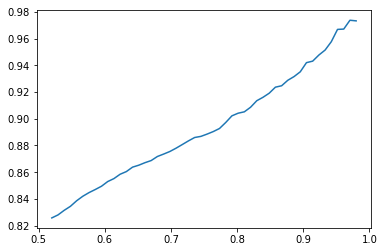

In [55]:
_ = plt.plot(alpha, f1s)

In [58]:
y_test_proba = model.predict_proba(X_test)
y_train_proba = model.predict_proba(X_train)
y_valid_proba = model.predict_proba(X_valid)

4064/4103 [============================>.] - ETA: 0s

In [59]:
y_proba = np.zeros(len(y_test_proba) + len(y_train_proba) + len(y_valid_proba), dtype=float)
y_proba.flat[idx_train] = y_train_proba
y_proba.flat[idx_test] = y_test_proba
y_proba.flat[idx_valid] = y_valid_proba

In [61]:
with open('scores.txt', 'w') as f:
  for i in y_proba.tolist():
    f.write('{:0.12f}\n'.format(i))

In [105]:
np.argsort(y_proba)[500:600]

array([10206,  3241,  2175,   173,  4594, 19887,  1315,  4142,  4119,
        3237, 13784, 11502, 11602, 12622, 17683,  2159, 19417, 18785,
        6607,  2494, 12069,  2990, 10216, 10241,  4591,  9711,  5531,
        5558, 11645, 12073,  9199, 16852, 16321, 14459, 15114,  7219,
        9718, 13812,  4108, 13208,  2160,  7674,  9189,  7226, 10213,
       17856,  2781, 12631, 19911,  1183,  8505,  5529, 19927, 14456,
       19764,  8626,  6076,  2992,  9208, 12099, 19411,  4117, 12669,
        5528,  6655,  8163,   142,  7237, 16307,   148,  2463,  7671,
        1289, 16302, 13173, 12627,  7227, 11530,  8623, 19396, 12111,
          59,  4423, 18407, 10208,  3655,  8622,  5480, 18848, 15577,
        4589,  2780,  5452,  5567,  5141, 13186, 17289,  3657, 10212,  2774])

In [90]:
with open('parsed-data-no-stops.pkl', 'r') as f:
  data = pickle.load(f)
  articles = [x[1] for x in data]
  urls = [x[3] for x in data]

In [114]:
idx = 19396
urls[idx], articles[idx]

(u'http://www.washingtontimes.com/news/2017/feb/20/howard-dean-kinda-backs-pete-buttigieg-be-dnc-chai/?utm_source=RSS_Feed&utm_medium=RSS',
 u'Howard Dean said Monday that he kinda is rooting for Pete Buttigieg in the race to become the next chair of the Democratic National Committee. Mr. Dean, who led the DNC from 2005 to 2009, has applauded Mr. Buttigieg, the mayor of South Bend, Ind., several times and took it a step further on Hardball with Chris Matthews. Asked whether he supported the 35-year-old, Mr. Dean said, I kinda am a little bit. Mr. Buttigieg has already received the support of three other former chairs: Joe Andrew, who led the DNC in 1999 to 2000, David Wilhelm, who chaired the DNC in 1993 to 1994 and Steve Grossman, who held the top post from 1997 to 1998. He has been viewed as the wild card in the race in which Rep. Keith Ellison and former Labor Secretary Tom Perez are the front runners. Mr. Buttigieg is hoping that the vote at the Feb. 25 DNC meeting ends in a stalem